# Renewal Pricing

### Load Data

In [474]:
# Import our dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import json
import math

#  Import and read the cleaned_data_seriously_forrealthistime.csv.

application_df = pd.read_csv("Resources/cleaned_data__seriously_forrealthistime.csv")
application_df.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24,male,30.1,87,No,0,No,southeast,1131.51
2,7,8,19,male,41.1,100,No,0,No,northwest,1146.80
3,8,9,20,male,43.0,86,No,0,No,northwest,1149.40
4,9,10,30,male,53.1,97,No,0,No,northwest,1163.46


### Creating Continuance Table

In [475]:
values,bins = np.histogram(application_df['claim'],bins=626,density=True)
print(len(values))
np.append(values,1,axis=None)
print(len(values))
print(len(bins))

626
626
627


### Storing the PMF

In [479]:
Sampling_Df = pd.DataFrame(
    {'Probability_Est':values,
    'Bin':bins}
)
Sampling_Df.head()

,Probability_Est,Bin
0,0.000045,1121.870000
1,0.000045,1221.947572
2,0.000008,1322.025144
3,0.000008,1422.102716
4,0.000060,1522.180288


### Assumed claims are well explained by poisson distribution, so Standard Deviation = Mean

In [480]:
#calculating variance of an assumed poisson distribution to add noise to claim samples (this is the same as the mean)
Lamb = application_df['claim'].mean()
print(Lamb)
# We want the STD
STD = math.sqrt(Lamb)
print(STD)

13325.246426426416
115.43503119255617


### Checking the Empirical CDF that we will be sampling

In [481]:
# Pretty Picture to see Percentiles
fig = px.ecdf(application_df,x='claim')
fig.show()

### Making separate DataFrame to populate

In [482]:
#copying the original DF
renewal_df = application_df.copy()
renewal_df.head()

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24,male,30.1,87,No,0,No,southeast,1131.51
2,7,8,19,male,41.1,100,No,0,No,northwest,1146.80
3,8,9,20,male,43.0,86,No,0,No,northwest,1149.40
4,9,10,30,male,53.1,97,No,0,No,northwest,1163.46


### Pulling in Death Probabilities and Modeling Population Decline

In [483]:
#Pulling the Other DataFrames
life = pd.read_csv('Resources/life.csv')

In [484]:
life.loc[renewal_df['age'][1]][1]
life = life.drop(120,axis=0)

In [485]:
life['Exact_Age'] = life['Exact_Age'].astype('float')
life['Male_Death_Prob'] = life['Male_Death_Prob'].astype('float')
life['Female_Death_Prob'] = life['Female_Death_Prob'].astype('float')
life.dtypes



Exact_Age            float64
Male_Death_Prob      float64
Female_Death_Prob    float64
dtype: object

In [486]:
# First Rolling for Deaths via custom function
def Deadifier (age,gender):
    #Lookup Probability of Death
        #Flipping the coin
        r = np.random.uniform(0,1)
        if (gender =='male'):
            #Male off of death
            p = life.loc[age][1]
        else:
            #Female odds of death
            p = life.loc[age][2]
            
            #Killing them off if they lost or advance their age if they roll higher than the 
        if (r > 1-p):
            #marking them as dead to not break the loop
            age = 'dead'
        else:
            #advancing age by one year 
            age = age + 1
        return(age)
# Check how many people died
i = 0
for rows in renewal_df:
    renewal_df['age'][i] = Deadifier(renewal_df['age'][i],renewal_df['gender'][i])
    i = i+1

#Checking the number of Deaths to check for objects
renewal_df['age'].value_counts()



C:\Users\ethan\AppData\Local\Temp\ipykernel_19584\355155811.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



43    50
26    47
46    44
30    43
32    42
40    42
27    41
37    41
48    40
45    40
31    39
34    39
29    39
42    38
47    37
36    37
49    37
28    36
33    35
44    35
35    35
38    33
25    33
50    33
23    28
20    27
19    27
55    26
39    25
22    24
41    23
59    22
60    21
57    21
21    19
52    18
56    18
54    17
51    17
58    17
18    16
53    15
24    15
Name: age, dtype: int64

### Enumerating Birth DataFrame for Modeling New Children

In [487]:
# Enumerating Column Data for kid rolling
ages = list(range(0,120,1))
Female_P = list([])
for age in ages: 
    if age < 15 or age > 49:
        p = 0
        Female_P.append(p)
    elif age < 20:
        p = 0.0199
        Female_P.append(p)
    elif age < 25 :
        p = 0.0722
        Female_P.append(p)
    elif age < 30:
        p = 0.0998
        Female_P.append(p)
    elif age < 35:
        p = 0.1002
        Female_P.append(p)
    elif age < 40:
        p = 0.0514
        Female_P.append(p)
    elif age < 45:
        p = 0.0111
        Female_P.append(p)
    elif age < 50:
        p = 0.0007
        Female_P.append(p)
    else:
        p = 0
        Female_P.append(p)
    

#Make the Male probs by the researched factor
Male_P = map(lambda x: x * 0.6923, Female_P)

# Then assigning Children Df
Kid_df = pd.DataFrame(
    {
        'Age':ages,
        'Female_Rate':Female_P,
        'Male_Rate':Male_P
    }
)

Kid_df.head(50)


,Age,Female_Rate,Male_Rate
0,0,0.0000,0.000000
1,1,0.0000,0.000000
2,2,0.0000,0.000000
3,3,0.0000,0.000000
4,4,0.0000,0.000000
5,5,0.0000,0.000000
6,6,0.0000,0.000000
7,7,0.0000,0.000000
8,8,0.0000,0.000000
9,9,0.0000,0.000000


In [488]:
# Rolling for Kids

# Function to add one or not
def Spawner (age,gender,children):
    # Lookup Probability of Death
        # Flipping the coin
        r = np.random.uniform(0,1)
        if (gender =='male'):
            # Male off of death
            p = Kid_df.loc[age][2]
        else:
            # Female odds of death
            p = Kid_df.loc[age][1]
            # Adding a kid if needed
        if (r > 1-p):
            # They had a kid
            children = children + 1
        return(children)
# Check how many people died
i = 0
for rows in renewal_df:
    renewal_df['children'][i] = Spawner(renewal_df['age'][i],renewal_df['gender'][i],renewal_df['children'][i])
    i = i+1

C:\Users\ethan\AppData\Local\Temp\ipykernel_19584\750898878.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [489]:
renewal_df['children'].value_counts()

0    567
1    325
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [490]:
application_df['children'].value_counts()

0    568
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [593]:
#See if anyone died!
print(list(renewal_df['age'].value_counts()))


[50, 47, 44, 43, 42, 42, 41, 41, 40, 40, 39, 39, 39, 38, 37, 37, 37, 36, 35, 35, 35, 33, 33, 33, 28, 27, 27, 26, 25, 24, 23, 22, 21, 21, 19, 18, 18, 17, 17, 17, 16, 15, 15]


No one died and 1 person had a kid!

## Now the fun part, Claims Predictions

In [598]:
# Then Rolling For Claim Amounts
test_df = Sampling_Df.sample(n=len(renewal_df['claim']),replace=True,weights=Sampling_Df['Probability_Est'],random_state=0,axis = 0)['Bin']
claims = test_df
print(claims.sum())

18198478.518466454


In [635]:
#Rolling for Claims and Altering Random States to Capture Possible Total Claims
claim_sums = []

for k in range(0,100):
    claims_df = renewal_df['claim'].copy()
    j = 0
    for rows in claims_df:
        claims_df[j] = Sampling_Df.sample(n=1,replace=True,weights=Sampling_Df['Probability_Est'],random_state=k,axis = 0)['Bin']
        claims_df[j] = claims_df[j]  + np.random.normal(loc=0,scale=STD,size=1)
        j = j+1

    claim_sums.append(claims_df.sum())

In [632]:
print(claims_df)
print(claims_df.sum())

0       10351.461473
1        7898.873677
2        8400.405151
3       10455.463503
4       44372.664796
            ...     
1327    11005.800423
1328     6574.529154
1329    42959.997576
1330     4171.441298
1331     1600.225037
Name: claim, Length: 1332, dtype: float64
17071915.43284554


### Simulation is done, now to analyze... 

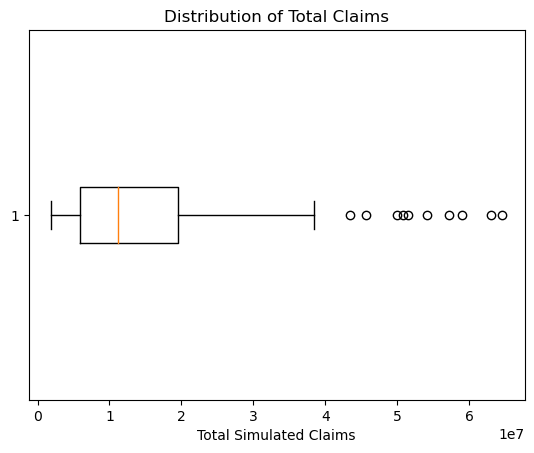

In [642]:
plt.boxplot(claim_sums,vert=False)
plt.title('Distribution of Total Claims')
plt.xlabel('Total Simulated Claims')
plt.axis()
plt.show()

In [643]:
Totals_df = pd.DataFrame(
    {
        'Total':claim_sums
    }
)

In [644]:
Totals_df.head(20)

,Total
0,1.388647e+07
1,1.028985e+07
2,1.096304e+07
3,1.389454e+07
4,5.894494e+07
5,5.893717e+06
6,4.561679e+07
7,2.832190e+06
8,3.841970e+07
9,1.895325e+06


In [649]:
stats = Totals_df['Total'].describe()

count    1.000000e+02
mean     1.657375e+07
std      1.552239e+07
min      1.895325e+06
25%      5.860610e+06
50%      1.115981e+07
75%      1.949385e+07
max      6.454897e+07
Name: Total, dtype: float64


In [ ]:
# Onto Fully Insured Pricing , We are assuming 1331 subscribers
# We will price assuming $0 ded for simplicity, but MOOP modeling can be easily implemented in the sampling algorithm

### Since we have an extremely long tail, we will assume 90th percentile for total claims 

In [652]:
# Retrieving expected claims
Estimated_Cost = np.quantile(Totals_df['Total'],0.9)
print(Estimated_Cost)

38925954.80854556


In [653]:
# Need to turn a profit, was generous with only doing 90% considering the high population of smokers and diabetics
Budget = Estimated_Cost*1.15
print(Budget)

44764848.02982739


In [655]:
# Now to calculate premiums
Num_Subs = len(renewal_df['PatientID'])
Months = 12
# Now Including the average medical cost growth trend
Monthly_Premium = Budget/Num_Subs/Months*1.07
Monthly_Premium

2996.6458578525594